In [1]:
# Validation of the steady-state simulation - Case 3: AeroCNN-II
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model
n_layers=4
n_kernels=200 # Number of kernels in convolutional network
kernel_size1=2
strides=1
n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate=0.1 # Defines the ratio of training dataset and test dataset
val_rate=0.2
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [5]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha
aa_ = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa_[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]
    
aa = aa_ / np.max(alpha)

In [6]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [7]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [8]:
## Creating input dataset - mask
mask_dir = main_directory + '\\aeroCNN2Mask'
os.chdir(mask_dir)
mask_list = os.listdir(mask_dir)
mask_target = [file for file in mask_list if file.endswith('.csv')]

In [9]:
mask_df = pd.DataFrame()
for file in mask_target:
    data = pd.read_csv(file, header=None)
    mask_df = pd.concat([mask_df, data], axis=0)

In [10]:
x = mask_df.iloc[:,:].values

In [11]:
x_alligned = np.zeros((x.shape[0],x.shape[1]))
for i in range(0,144*2):
    if i%2==0:
        x_alligned[i*100:(i+1)*100,:] = x[i*100:(i+1)*100,:]
    else:
        x_alligned[i*100:(i+1)*100,:] = x[i*100:(i+1)*100,:].T


In [12]:
x = x_alligned.reshape((16*9,2,input_size,input_size))

In [13]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]
os.chdir(main_directory)

In [14]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [15]:
cd_orig = target_df.iloc[:,4].values # Cd values
#target_c4 = target_df.iloc[:,4].values# Cl values

In [16]:
cl = (cd_orig-np.min(cd_orig))/(np.max(cd_orig)-np.min(cd_orig))

In [17]:
y = cl.reshape((-1,1))

In [18]:
x_all, x_test, y_all, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [19]:
x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=val_rate/(1-test_rate), random_state=1)

In [20]:
x_train.shape

(100, 2, 100, 100)

In [21]:
y_train.shape

(100, 1)

In [22]:
tf.keras.backend.set_image_data_format('channels_first')

In [23]:
input_image = tf.keras.Input(shape=(2, input_size, input_size))

x_conv1 = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(input_image)
x1_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv1)
x_conv2 = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(x1_)
x2_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv2)
x_conv3 = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(x2_)
x3_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv3)
x_conv4 = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(x3_)
x4_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv4)
x_flat = tf.keras.layers.Flatten()(x4_)
x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(x_flat)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc5)
# AeroCNN-II based
model = tf.keras.Model(input_image, output_data)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 100, 100)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 100, 100)     1800      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 50, 50)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 50, 50)       160200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 200, 25, 25)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 200, 25, 25)       160200

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [26]:
model_directory = "D:\\TrainedModels\\20221130"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [27]:
# ckpt_name = model_directory + "\\20221130steadyValidation_AeroCNN2_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" + str(n_units) +"units_OptimalSettings_Cdcheckpoint.h5"

# ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-09, min_lr=1e-06, verbose=1)

In [28]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [29]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/10000
5/5 [==============================] - 5s 70ms/step - loss: 0.1406 - rmse: 0.3749 - val_loss: 0.0211 - val_rmse: 0.1453 - lr: 1.0000e-04
Epoch 2/10000
5/5 [==============================] - 0s 24ms/step - loss: 0.0155 - rmse: 0.1245 - val_loss: 0.0127 - val_rmse: 0.1127 - lr: 1.0000e-04
Epoch 3/10000
5/5 [==============================] - 0s 24ms/step - loss: 0.0099 - rmse: 0.0993 - val_loss: 0.0104 - val_rmse: 0.1018 - lr: 1.0000e-04
Epoch 4/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.0081 - rmse: 0.0901 - val_loss: 0.0142 - val_rmse: 0.1191 - lr: 1.0000e-04
Epoch 5/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.0064 - rmse: 0.0798 - val_loss: 0.0112 - val_rmse: 0.1056 - lr: 1.0000e-04
Epoch 6/10000
5/5 [==============================] - 0s 25ms/step - loss: 0.0055 - rmse: 0.0740 - val_loss: 0.0071 - val_rmse: 0.0842 - lr: 1.0000e-04
Epoch 7/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.0040 - rmse: 0.063

Epoch 107/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.1442e-04 - rmse: 0.0107 - val_loss: 0.0096 - val_rmse: 0.0979 - lr: 1.0000e-04
Epoch 108/10000
5/5 [==============================] - 0s 21ms/step - loss: 9.2608e-05 - rmse: 0.0096 - val_loss: 0.0097 - val_rmse: 0.0984 - lr: 1.0000e-04
Epoch 109/10000
5/5 [==============================] - 0s 21ms/step - loss: 8.3018e-05 - rmse: 0.0091 - val_loss: 0.0095 - val_rmse: 0.0973 - lr: 1.0000e-04
Epoch 110/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.0338e-04 - rmse: 0.0102 - val_loss: 0.0098 - val_rmse: 0.0990 - lr: 1.0000e-04
Epoch 111/10000
5/5 [==============================] - 0s 21ms/step - loss: 8.3741e-05 - rmse: 0.0092 - val_loss: 0.0097 - val_rmse: 0.0987 - lr: 1.0000e-04
Epoch 112/10000
5/5 [==============================] - 0s 21ms/step - loss: 4.2524e-05 - rmse: 0.0065 - val_loss: 0.0097 - val_rmse: 0.0986 - lr: 1.0000e-04
Epoch 113/10000
5/5 [==============================] - 0s 

Epoch 212/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.8430e-04 - rmse: 0.0136 - val_loss: 0.0082 - val_rmse: 0.0903 - lr: 1.0000e-04
Epoch 213/10000
5/5 [==============================] - ETA: 0s - loss: 8.2878e-05 - rmse: 0.0091
Epoch 213: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
5/5 [==============================] - 0s 21ms/step - loss: 8.2878e-05 - rmse: 0.0091 - val_loss: 0.0088 - val_rmse: 0.0936 - lr: 1.0000e-04
Epoch 214/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.6402e-05 - rmse: 0.0075 - val_loss: 0.0085 - val_rmse: 0.0920 - lr: 5.0000e-05
Epoch 215/10000
5/5 [==============================] - 0s 21ms/step - loss: 3.8512e-05 - rmse: 0.0062 - val_loss: 0.0084 - val_rmse: 0.0918 - lr: 5.0000e-05
Epoch 216/10000
5/5 [==============================] - 0s 21ms/step - loss: 4.2994e-05 - rmse: 0.0066 - val_loss: 0.0085 - val_rmse: 0.0919 - lr: 5.0000e-05
Epoch 217/10000
5/5 [==============================] - 0

5/5 [==============================] - 0s 20ms/step - loss: 6.8195e-06 - rmse: 0.0026 - val_loss: 0.0086 - val_rmse: 0.0925 - lr: 5.0000e-05
Epoch 316/10000
5/5 [==============================] - 0s 20ms/step - loss: 6.0102e-06 - rmse: 0.0025 - val_loss: 0.0088 - val_rmse: 0.0937 - lr: 5.0000e-05
Epoch 317/10000
5/5 [==============================] - 0s 20ms/step - loss: 5.1556e-06 - rmse: 0.0023 - val_loss: 0.0087 - val_rmse: 0.0934 - lr: 5.0000e-05
Epoch 318/10000
5/5 [==============================] - 0s 21ms/step - loss: 4.4578e-06 - rmse: 0.0021 - val_loss: 0.0087 - val_rmse: 0.0933 - lr: 5.0000e-05
Epoch 319/10000
5/5 [==============================] - 0s 21ms/step - loss: 3.1655e-06 - rmse: 0.0018 - val_loss: 0.0087 - val_rmse: 0.0932 - lr: 5.0000e-05
Epoch 320/10000
5/5 [==============================] - 0s 21ms/step - loss: 3.0049e-06 - rmse: 0.0017 - val_loss: 0.0087 - val_rmse: 0.0930 - lr: 5.0000e-05
Epoch 321/10000
5/5 [==============================] - 0s 20ms/step - loss

5/5 [==============================] - 0s 21ms/step - loss: 1.7626e-06 - rmse: 0.0013 - val_loss: 0.0087 - val_rmse: 0.0933 - lr: 2.5000e-05
Epoch 419/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.4914e-06 - rmse: 0.0012 - val_loss: 0.0087 - val_rmse: 0.0931 - lr: 2.5000e-05
Epoch 420/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.4007e-06 - rmse: 0.0012 - val_loss: 0.0087 - val_rmse: 0.0933 - lr: 2.5000e-05
Epoch 421/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.2323e-06 - rmse: 0.0011 - val_loss: 0.0087 - val_rmse: 0.0932 - lr: 2.5000e-05
Epoch 422/10000
5/5 [==============================] - 0s 20ms/step - loss: 1.2892e-06 - rmse: 0.0011 - val_loss: 0.0087 - val_rmse: 0.0933 - lr: 2.5000e-05
Epoch 423/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.2544e-06 - rmse: 0.0011 - val_loss: 0.0087 - val_rmse: 0.0932 - lr: 2.5000e-05
Epoch 424/10000
5/5 [==============================] - 0s 21ms/step - loss

Epoch 470/10000
5/5 [==============================] - 0s 21ms/step - loss: 9.0655e-07 - rmse: 9.5213e-04 - val_loss: 0.0087 - val_rmse: 0.0933 - lr: 2.5000e-05
Epoch 471/10000
5/5 [==============================] - 0s 21ms/step - loss: 9.1965e-07 - rmse: 9.5898e-04 - val_loss: 0.0087 - val_rmse: 0.0932 - lr: 2.5000e-05
Epoch 472/10000
5/5 [==============================] - 0s 21ms/step - loss: 9.6987e-07 - rmse: 9.8482e-04 - val_loss: 0.0087 - val_rmse: 0.0933 - lr: 2.5000e-05
Epoch 473/10000
5/5 [==============================] - 0s 21ms/step - loss: 8.5120e-07 - rmse: 9.2260e-04 - val_loss: 0.0087 - val_rmse: 0.0934 - lr: 2.5000e-05
Epoch 474/10000
5/5 [==============================] - 0s 21ms/step - loss: 9.5138e-07 - rmse: 9.7539e-04 - val_loss: 0.0087 - val_rmse: 0.0933 - lr: 2.5000e-05
Epoch 475/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.1142e-06 - rmse: 0.0011 - val_loss: 0.0087 - val_rmse: 0.0932 - lr: 2.5000e-05
Epoch 476/10000
5/5 [=================

Epoch 573/10000
5/5 [==============================] - 0s 21ms/step - loss: 9.7480e-07 - rmse: 9.8732e-04 - val_loss: 0.0087 - val_rmse: 0.0933 - lr: 2.5000e-05
Epoch 574/10000
5/5 [==============================] - 0s 20ms/step - loss: 8.8623e-07 - rmse: 9.4140e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 2.5000e-05
Epoch 575/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.0647e-06 - rmse: 0.0010 - val_loss: 0.0087 - val_rmse: 0.0934 - lr: 2.5000e-05
Epoch 576/10000
5/5 [==============================] - 0s 21ms/step - loss: 8.8667e-07 - rmse: 9.4163e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 2.5000e-05
Epoch 577/10000
5/5 [==============================] - 0s 21ms/step - loss: 8.9122e-07 - rmse: 9.4404e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 2.5000e-05
Epoch 578/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.0203e-06 - rmse: 0.0010 - val_loss: 0.0087 - val_rmse: 0.0933 - lr: 2.5000e-05
Epoch 579/10000
5/5 [=====================

Epoch 674/10000
5/5 [==============================] - 0s 21ms/step - loss: 4.3006e-07 - rmse: 6.5579e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 1.2500e-05
Epoch 675/10000
5/5 [==============================] - 0s 20ms/step - loss: 3.9514e-07 - rmse: 6.2860e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 1.2500e-05
Epoch 676/10000
5/5 [==============================] - 0s 20ms/step - loss: 4.4734e-07 - rmse: 6.6884e-04 - val_loss: 0.0088 - val_rmse: 0.0936 - lr: 1.2500e-05
Epoch 677/10000
5/5 [==============================] - 0s 21ms/step - loss: 4.9200e-07 - rmse: 7.0143e-04 - val_loss: 0.0087 - val_rmse: 0.0934 - lr: 1.2500e-05
Epoch 678/10000
5/5 [==============================] - 0s 21ms/step - loss: 5.2690e-07 - rmse: 7.2588e-04 - val_loss: 0.0087 - val_rmse: 0.0934 - lr: 1.2500e-05
Epoch 679/10000
5/5 [==============================] - 0s 21ms/step - loss: 3.1737e-07 - rmse: 5.6335e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 1.2500e-05
Epoch 680/10000
5/5 [=============

Epoch 725/10000
5/5 [==============================] - 0s 21ms/step - loss: 3.3760e-07 - rmse: 5.8103e-04 - val_loss: 0.0087 - val_rmse: 0.0934 - lr: 1.2500e-05
Epoch 726/10000
5/5 [==============================] - 0s 20ms/step - loss: 2.7244e-07 - rmse: 5.2196e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 1.2500e-05
Epoch 727/10000
5/5 [==============================] - 0s 21ms/step - loss: 3.3217e-07 - rmse: 5.7634e-04 - val_loss: 0.0087 - val_rmse: 0.0934 - lr: 1.2500e-05
Epoch 728/10000
5/5 [==============================] - 0s 21ms/step - loss: 3.6258e-07 - rmse: 6.0215e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 1.2500e-05
Epoch 729/10000
5/5 [==============================] - 0s 21ms/step - loss: 3.4065e-07 - rmse: 5.8365e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 1.2500e-05
Epoch 730/10000
5/5 [==============================] - 0s 21ms/step - loss: 3.4672e-07 - rmse: 5.8883e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 1.2500e-05
Epoch 731/10000
5/5 [=============

Epoch 776/10000
5/5 [==============================] - 0s 20ms/step - loss: 3.0208e-07 - rmse: 5.4962e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 1.2500e-05
Epoch 777/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.5719e-07 - rmse: 5.0714e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 1.2500e-05
Epoch 778/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.5812e-07 - rmse: 5.0805e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 1.2500e-05
Epoch 779/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.6267e-07 - rmse: 5.1251e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 1.2500e-05
Epoch 780/10000
5/5 [==============================] - 0s 20ms/step - loss: 2.8229e-07 - rmse: 5.3131e-04 - val_loss: 0.0088 - val_rmse: 0.0936 - lr: 1.2500e-05
Epoch 781/10000
5/5 [==============================] - 0s 20ms/step - loss: 2.2893e-07 - rmse: 4.7846e-04 - val_loss: 0.0087 - val_rmse: 0.0934 - lr: 1.2500e-05
Epoch 782/10000
5/5 [=============

Epoch 826/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.9541e-07 - rmse: 4.4206e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 6.2500e-06
Epoch 827/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.7731e-07 - rmse: 4.2108e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 6.2500e-06
Epoch 828/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.7525e-07 - rmse: 4.1863e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 6.2500e-06
Epoch 829/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.9452e-07 - rmse: 4.4105e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 6.2500e-06
Epoch 830/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.8524e-07 - rmse: 4.3039e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 6.2500e-06
Epoch 831/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.7985e-07 - rmse: 4.2409e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 6.2500e-06
Epoch 832/10000
5/5 [=============

Epoch 877/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.6398e-07 - rmse: 5.1379e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 6.2500e-06
Epoch 878/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.0981e-07 - rmse: 4.5805e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 6.2500e-06
Epoch 879/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.2935e-07 - rmse: 4.7891e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 6.2500e-06
Epoch 880/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.1785e-07 - rmse: 4.6674e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 6.2500e-06
Epoch 881/10000
5/5 [==============================] - 0s 20ms/step - loss: 2.7491e-07 - rmse: 5.2432e-04 - val_loss: 0.0088 - val_rmse: 0.0935 - lr: 6.2500e-06
Epoch 882/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.4700e-07 - rmse: 3.8340e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 6.2500e-06
Epoch 883/10000
5/5 [=============

Epoch 928/10000
5/5 [==============================] - 0s 20ms/step - loss: 1.5007e-07 - rmse: 3.8739e-04 - val_loss: 0.0088 - val_rmse: 0.0936 - lr: 6.2500e-06
Epoch 929/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.6462e-07 - rmse: 4.0574e-04 - val_loss: 0.0088 - val_rmse: 0.0936 - lr: 6.2500e-06
Epoch 930/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.7591e-07 - rmse: 4.1942e-04 - val_loss: 0.0088 - val_rmse: 0.0935 - lr: 6.2500e-06
Epoch 931/10000
5/5 [==============================] - 0s 20ms/step - loss: 1.7711e-07 - rmse: 4.2085e-04 - val_loss: 0.0088 - val_rmse: 0.0936 - lr: 6.2500e-06
Epoch 932/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.4138e-07 - rmse: 3.7600e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 6.2500e-06
Epoch 933/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.6812e-07 - rmse: 4.1002e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 6.2500e-06
Epoch 934/10000
5/5 [=============

Epoch 979/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.5588e-07 - rmse: 3.9482e-04 - val_loss: 0.0087 - val_rmse: 0.0935 - lr: 6.2500e-06
Epoch 980/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.5887e-07 - rmse: 3.9859e-04 - val_loss: 0.0088 - val_rmse: 0.0936 - lr: 6.2500e-06
Epoch 981/10000
5/5 [==============================] - 0s 21ms/step - loss: 2.2786e-07 - rmse: 4.7735e-04 - val_loss: 0.0088 - val_rmse: 0.0936 - lr: 6.2500e-06
Epoch 982/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.8531e-07 - rmse: 4.3048e-04 - val_loss: 0.0088 - val_rmse: 0.0936 - lr: 6.2500e-06
Epoch 983/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.5202e-07 - rmse: 3.8990e-04 - val_loss: 0.0088 - val_rmse: 0.0935 - lr: 6.2500e-06
Epoch 984/10000
5/5 [==============================] - 0s 21ms/step - loss: 1.3952e-07 - rmse: 3.7352e-04 - val_loss: 0.0088 - val_rmse: 0.0936 - lr: 6.2500e-06
Epoch 985/10000
5/5 [=============

In [30]:
time = end - start
print("Training time:", time)

Training time: 0:01:44.759408


In [31]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221205AeroCNN2_optimalSettings\\test"+str(test_rate)+"Clonly"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

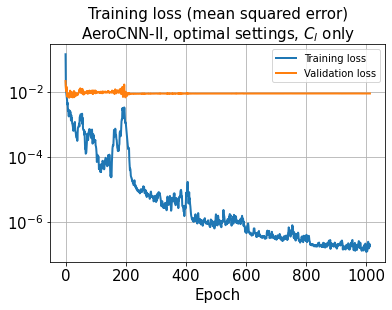

In [32]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-II, optimal settings, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

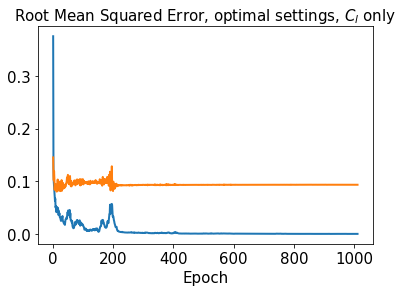

In [33]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

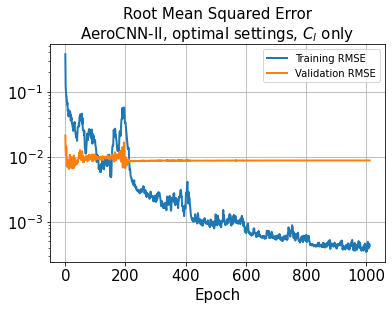

In [34]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-II, optimal settings, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [35]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 17ms/step - loss: 0.0017 - rmse: 0.0410


In [36]:
test_results = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 62ms/step - loss: 0.0038 - rmse: 0.0614


In [37]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

1/1 [==============================] - 0s 15ms/step


In [40]:
index_train = np.unique(np.where(np.isin(cl, y_train)))
index_val = np.unique(np.where(np.isin(cl, y_val)))
index_test = np.unique(np.where(np.isin(cl, y_test)))

In [42]:
y_train = y_train*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
y_val = y_val*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
y_test = y_test*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)

In [44]:
decoded_train = decoded_train_*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
decoded_val = decoded_val_*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
decoded_test = decoded_test_*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)

In [45]:
model_directory = "D:\\TrainedModels\\20221205"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221205steadyValidation_AeroCNN2_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels) +"units_optimalSettings_Clonly.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [46]:
error_train_abs = np.abs(decoded_train - y_train)

In [47]:
error_test_abs = np.abs(decoded_test - y_test)

In [48]:
os.chdir(storage_dir)

In [49]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.06267278603123777


In [50]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.13803770478427543


In [51]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.09180652199160984


In [52]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [53]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum((y_val[i]+1e-07)**2))
    l2_error_val_list.append(l2_error_val_data)

In [54]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

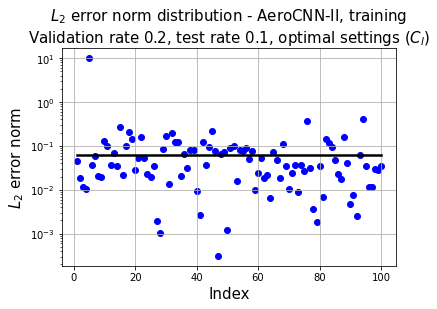

In [55]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\nValidation rate {0}, test rate {1}, optimal settings ($C_l$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

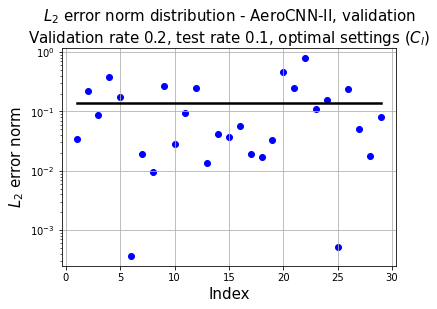

In [56]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, validation\nValidation rate {0}, test rate {1}, optimal settings ($C_l$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

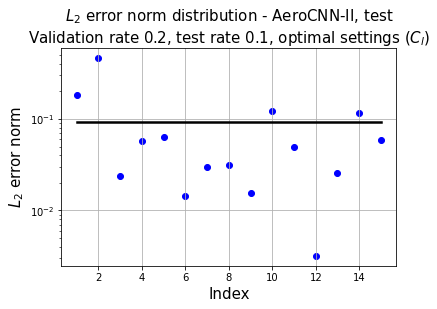

In [57]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, test\nValidation rate {0}, test rate {1}, optimal settings ($C_l$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [58]:
predicted = model.predict(x)

5/5 [==============================] - 0s 89ms/step


In [72]:
def CD_trainTestSplit_Plot(i, CL, cl, aTrain, aTest, iTrain, iTest):
    
    #title_0_Cd = 'Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd
    title_0_Cl = 'Gurney flap not attached (NACA0018)\n$C_L$ prediction, L2 error=%.4f' % l2_error_Cl
    
    #title_n_Cd = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_D$ prediction, L2 error=%.4f'%(l2_error_Cd)
    title_n_Cl = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_L$ prediction, L2 error=%.4f'%(l2_error_Cl)
    
    if i==0:
#         title_Cd, title_Cl = title_0_Cd, title_0_Cl
#         savename1,savename2 = "CdComparison_NACA0018.jpg", "ClComparison_NACA0018.jpg"
        title_Cl = title_0_Cl
        savename2 = "ClComparison_NACA0018.jpg"
    else:
#         title_Cd, title_Cl = title_n_Cd, title_n_Cl
        title_Cl = title_n_Cl
        #savename1 = "CdComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    ''' # CD graph plot
    plt.plot(alpha, CD, 'k-', label='Ground truth')
    plt.plot(alpha, cl, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain, color='b', label='Training set')
    plt.scatter(aVal, iVal, color='g', label='Validation set')
    plt.scatter(aTest, iTest, color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_D$')
    plt.title(title_Cd, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 0.12])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()'''
    # CL graph plot
    plt.plot(alpha, CL, 'k-', label='Ground truth')
    plt.plot(alpha, cl, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain, color='b', label='Training set')
    plt.scatter(aVal, iVal, color='g', label='Validation set')
    plt.scatter(aTest, iTest, color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_L$')
    plt.title(title_Cl, fontsize=15)
    plt.legend(loc='upper left')
    plt.ylim([0, 2])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

1/1 [==============================] - 0s 15ms/step
NACA0018 airfoil without Gurney flap
L2 error of Cd: 0.0400


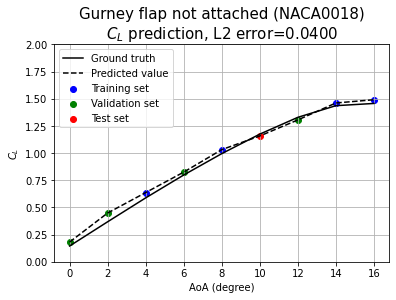

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0305


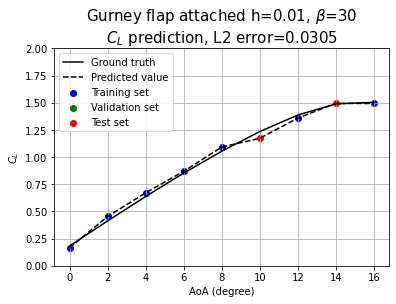

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0338


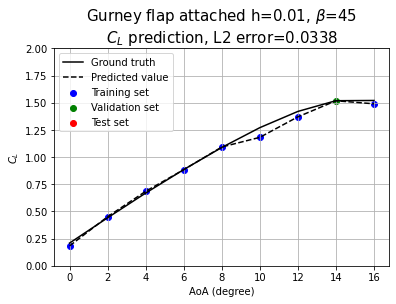

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0374


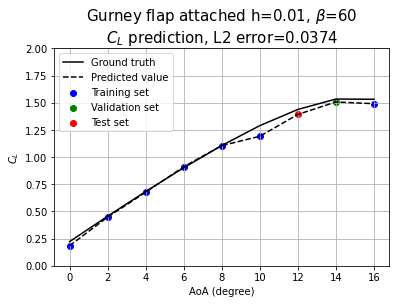

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0368


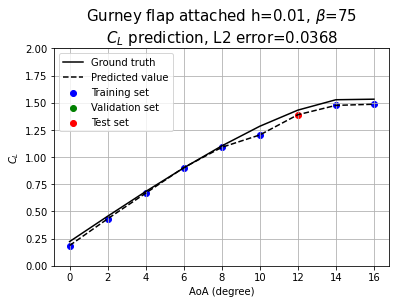

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0871


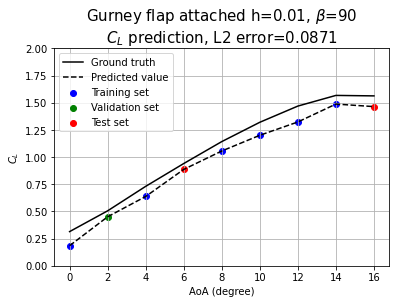

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0544


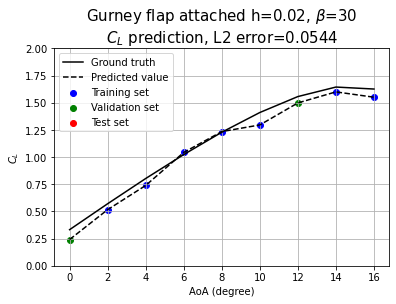

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0548


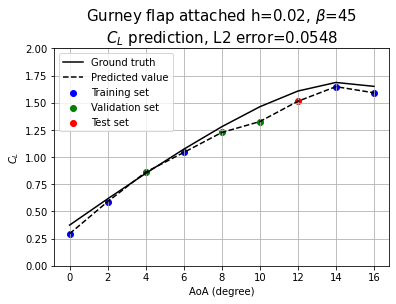

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0515


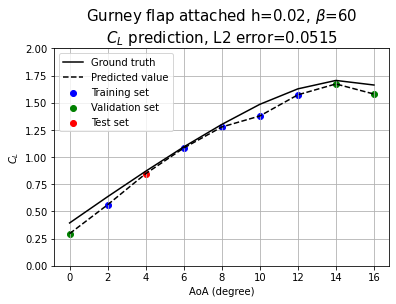

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0769


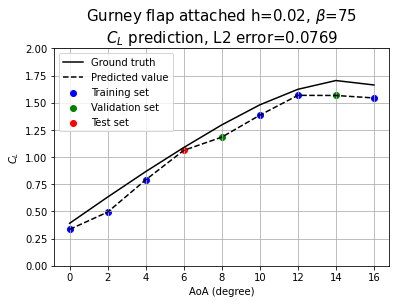

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.2065


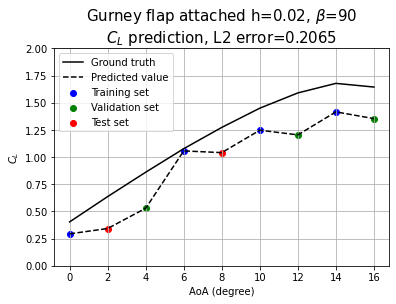

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0528


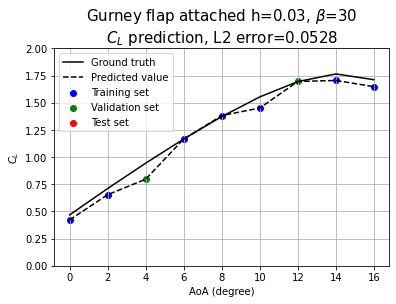

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0388


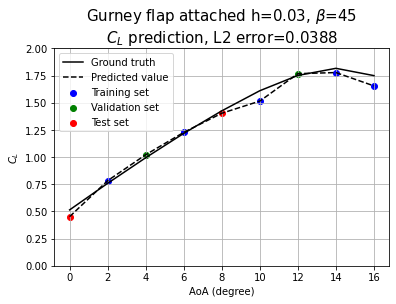

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0219


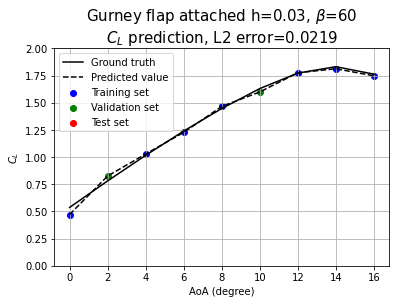

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0597


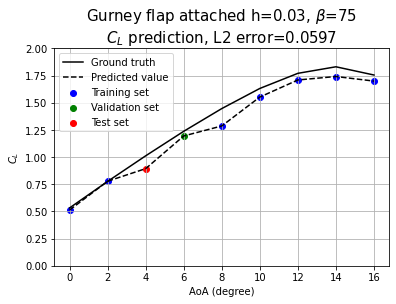

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.3126


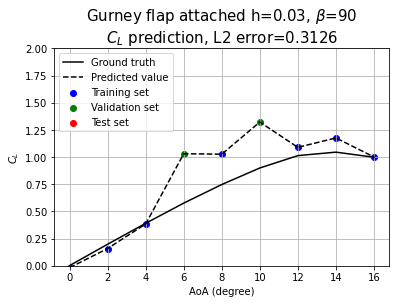

In [73]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]
for i in range(0, 16):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    alpha_train = []
    alpha_val = []
    alpha_test = []
    
    predictedValue = model.predict(x[n_alpha*i:n_alpha*(i+1),:])
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    l2_error_Cl = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cd: {0:0.4f}'.format(l2_error_Cd))
    else:
        print('L2 error of Cd: {0:0.4f}'.format(l2_error_Cl))
    
    cl = predicted[n_alpha*i:n_alpha*(i+1)]*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    CL = y[n_alpha*i:n_alpha*(i+1)]*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        iVal.append(predicted[index])    
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    iTest = np.array(iTest)*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    iVal = np.array(iVal)*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        alpha_val.append(aa[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)*np.max(alpha)
    aVal = np.array(alpha_val)*np.max(alpha)
    aTest = np.array(alpha_test)*np.max(alpha)
    
    CD_trainTestSplit_Plot(i, CL, cl, aTrain, aTest, iTrain, iTest)